In [1]:
from rdkit import Chem

poses=Chem.SDMolSupplier('lig-dump-rec-1.all_poses.sdf')
renamed_poses=[]
for index,p in enumerate(poses):
    p.SetProp('_Name',str(index+1))
    renamed_poses.append(p)

INFO:rdkit:Enabling RDKit 2021.09.4 jupyter extensions


/Users/williammccorkindale/miniconda3/envs/molplotly/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


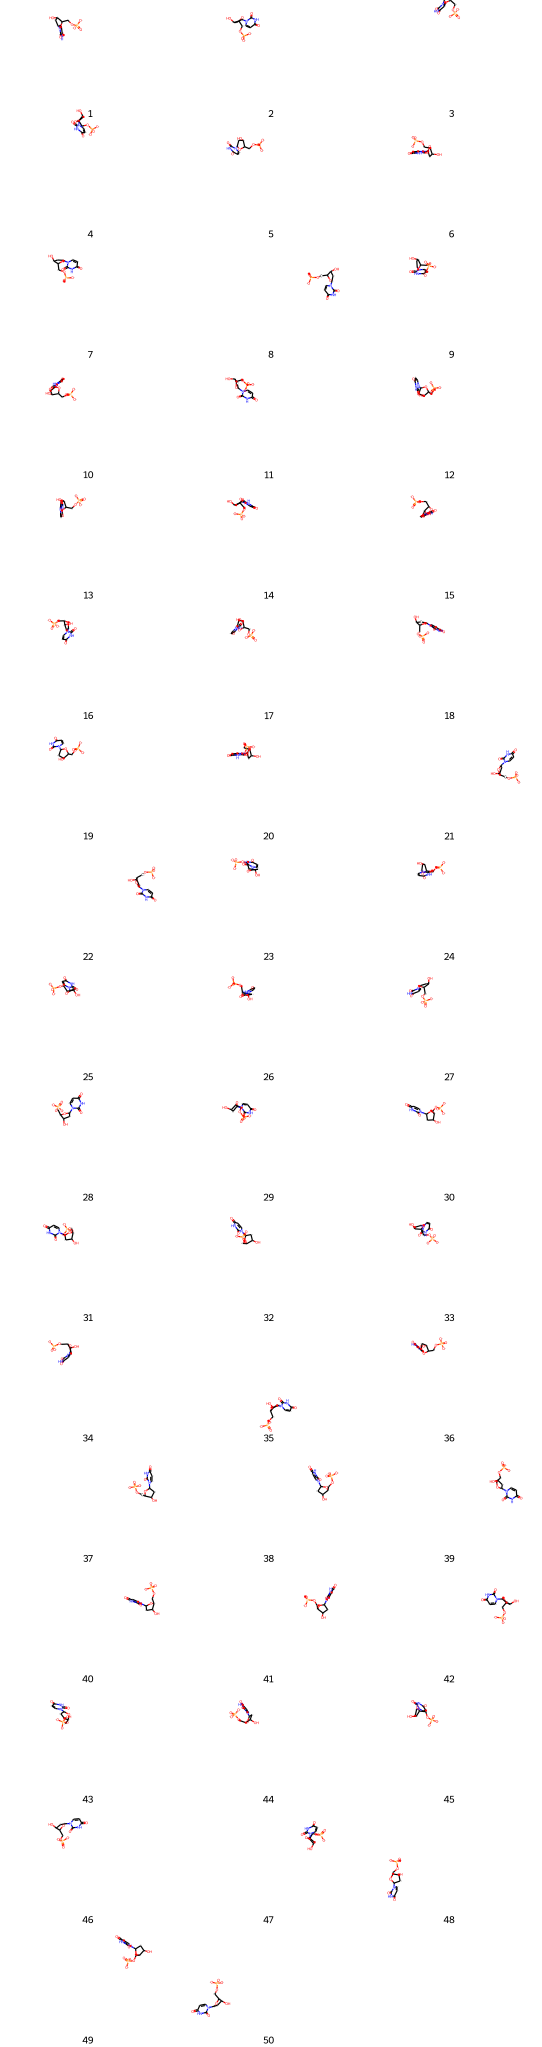

In [2]:
from rdkit.Chem import Draw
# If all molecules are correct (sanitized), Draw.MolsToGridImage must work 
img=Draw.MolsToGridImage(renamed_poses,molsPerRow=(3), subImgSize=(300,200), legends=[i.GetProp('_Name') for i in renamed_poses],useSVG=True)
img

In [3]:
from rdkit.Chem import PandasTools

poses=PandasTools.LoadSDF('lig-dump-rec-1.all_poses.sdf',molColName='Mol')
pose_prot=PandasTools.LoadSDF('1.sdf',molColName='Mol')

RDKit WARNING: [15:56:28] WARNING: not removing hydrogen atom without neighbors
[15:56:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:28] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:56:28] WARNING: not removing hydrogen atom without neighbors
[15:56:28] WARNING: not removing hydrogen atom without neighbors
[15:56:28] WARNING: not removing hydrogen atom without neighbors


In [4]:
import numpy as np
import pandas as pd
from rdkit.Chem import rdFMCS

size=len(renamed_poses)
hmap=np.empty(shape=(size,size))
table=pd.DataFrame()
for i,mol in enumerate(renamed_poses):
    for j,jmol in enumerate(renamed_poses):
        # MCS identification between reference pose and target pose
        r=rdFMCS.FindMCS([mol,jmol])
        # Atom map for reference and target              
        a=mol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        b=jmol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        # Atom map generation     
        amap=list(zip(a,b))
        
        # distance calculation per atom pair
        distances=[]
        for atomA, atomB in amap:
            pos_A=mol.GetConformer().GetAtomPosition (atomA)
            pos_B=jmol.GetConformer().GetAtomPosition (atomB)
            coord_A=np.array((pos_A.x,pos_A.y,pos_A.z))
            coord_B=np.array ((pos_B.x,pos_B.y,pos_B.z))
            dist_numpy = np.linalg.norm(coord_A-coord_B)        
            distances.append(dist_numpy)
                         
        # This is the RMSD formula from wikipedia
        rmsd=np.sqrt(1/len(distances)*sum([i*i for i in distances])) 
        
        #saving the rmsd values to a matrix and a table for clustering
        hmap[i,j]=rmsd
        table.loc[mol.GetProp('_Name'),jmol.GetProp('_Name')]=rmsd

/var/folders/b1/zflg536s6rvg62mcvlc7dnnw0000gn/T/ipykernel_22321/4196631765.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[mol.GetProp('_Name'),jmol.GetProp('_Name')]=rmsd
/var/folders/b1/zflg536s6rvg62mcvlc7dnnw0000gn/T/ipykernel_22321/4196631765.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  table.loc[mol.GetProp('_Name'),jmol.GetProp('_Name')]=rmsd
/var/folders/b1/zflg536s6rvg62mcvlc7dnnw0000gn/T/ipykernel_22321/4196631765.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

In [5]:
table

,1,2,3,4,5,6,7,8,9,10,...,100,101,102,103,104,105,106,107,108,109
1,0.000000,4.968762,18.510436,17.529554,2.241701,4.333559,4.619198,20.232644,2.615493,4.686850,...,18.994891,20.863577,18.082664,17.922045,20.359698,3.684359,17.359691,18.368810,20.795386,18.716521
2,4.968762,0.000000,18.522615,17.625583,5.444812,6.007267,1.685385,20.035788,5.473260,3.603816,...,19.646872,20.547762,17.972569,18.498870,20.058672,6.188700,16.627999,18.159665,20.565234,18.716114
3,18.510436,18.522615,0.000000,2.543105,18.487279,20.152921,18.166205,24.456125,19.107693,20.133274,...,23.768530,17.296175,23.148776,22.110506,23.047901,19.837693,19.631997,22.658919,17.586144,22.695927
4,17.529554,17.625583,2.543105,0.000000,17.482198,19.136053,17.333694,24.342395,17.962845,19.211858,...,23.500360,16.998626,22.809783,21.759267,22.873557,18.840750,19.413797,22.294452,17.151875,22.224109
5,2.241701,5.444812,18.487279,17.482198,0.000000,4.324909,5.360390,20.917745,2.526450,4.809410,...,19.457599,20.744543,18.541485,18.402582,20.994521,3.352975,17.130690,19.151903,20.664929,18.474082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,3.684359,6.188700,19.837693,18.840750,3.352975,3.036430,6.244924,19.892094,3.822457,4.897547,...,18.380468,21.569336,17.622064,17.783704,20.044122,0.000000,17.976844,18.187574,21.703158,18.948411
106,17.359691,16.627999,19.631997,19.413797,17.130690,17.579957,16.484192,30.126319,17.452484,16.981365,...,30.776724,8.369785,30.124140,30.449981,30.967346,17.976844,0.000000,29.522529,8.310004,6.310996
107,18.368810,18.159665,22.658919,22.294452,19.151903,19.091884,17.793692,4.990604,19.185339,19.174685,...,5.592371,30.472172,5.294678,6.074367,3.955231,18.187574,29.522529,0.000000,31.180128,30.582001
108,20.795386,20.565234,17.586144,17.151875,20.664929,21.319783,20.337419,32.283474,20.596482,21.268425,...,32.671188,2.262683,32.411417,32.299259,32.530696,21.703158,8.310004,31.180128,0.000000,9.207359


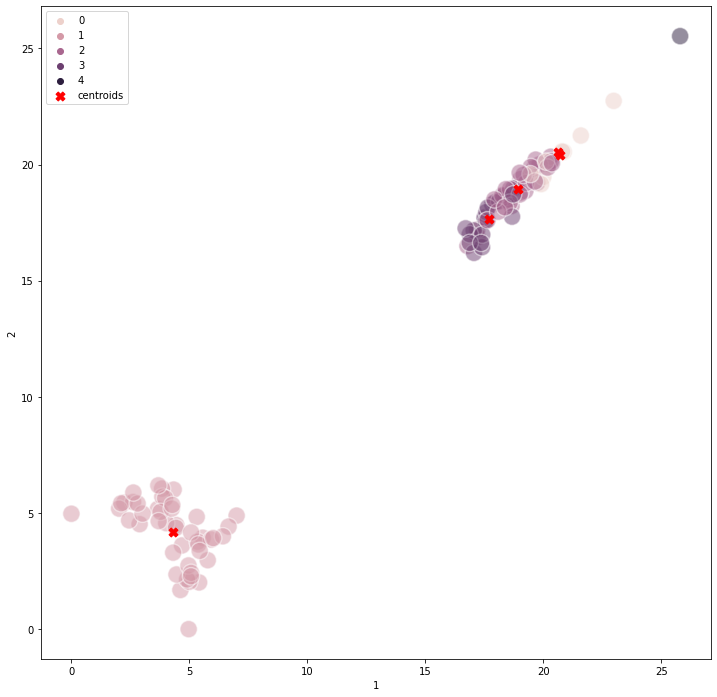

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


#https://sites.google.com/view/aide-python/graphiques/explorer-et-visualiser-les-donn%C3%A9es-dune-dataframe?authuser=0#h.p_qOXB4jjAR5rI
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, ).fit(table)
figure= plt.figure(figsize=(12,12))

sns.scatterplot(data=table, x="1", y="2", hue=kmeans.labels_, alpha=0.5, s=300)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")

plt.legend()
plt.show()

In [8]:
import plotly.express as px

table['pose_index'] = [f'Molecule Index: {index}' for index in table.index]
table['cluster'] = kmeans.labels_
table['cluster'] = table['cluster'].astype(str)

px.scatter(table, 
            x="1", 
            y="2",
            color='cluster',
            hover_name='pose_index',
            width=1000,
            height=800)

In [9]:
import molplotly

table['pose_index'] = table.index
table['cluster'] = kmeans.labels_
table['cluster'] = table['cluster'].astype(str)
table['mol'] = renamed_poses 

fig_clusters = px.scatter(table, 
                    x="1", 
                    y="2",
                    color='cluster',
                    width=1000,
                    height=800)

app_clusters = molplotly.add_molecules(
    fig=fig_clusters,
    df=table,
    mol_col="mol",
    color_col='cluster',
    caption_cols=["pose_index"],
    show_coords=True,
)

app_clusters.run_server(mode="inline", port=8704, height=850)
